### 12/18/24
---
##### Where are we...
- We have filepaths for every model we want to look at 29
- We have pre processing that takes care of time and lat cropping. and interpolation to GFDL grid
- Do this in the local storage - so processing will have to happen one model at a time - and some output file

##### Where are we going...
- Adding landMask - shouldn't be crazy
- Do some net metrics - grid means, land means, ocean means, and model tag
- Doing pdfs (if thats the move?)

---
 ### First Project - Get Info and Add Landgrid/easy calculations

In [1]:
import sys
sys.path.append('/home/users/chingosa/TropExt/Functions/')
import CMIPFuncs as func
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats 
import os
import cftime
import requests
from tqdm import tqdm
from dask.diagnostics import ProgressBar
filePaths = pd.read_csv('TempData/CO2_4x_url_reduced_wMon.csv', index_col = None)


In [2]:
def grabDS(model, period, Vars):
    try:
        return xr.open_mfdataset([f'TempData/{model}_{period}_{Var}_processed.nc' for Var in Vars], use_cftime = True)
    except:
        print('No File Found')

def AddLandMask(ds):
    landMask = xr.open_dataset('/badc/cmip6/data/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp245/r1i1p1f1/fx/sftlf/gr1/latest/sftlf_fx_GFDL-CM4_ssp245_r1i1p1f1_gr1.nc').sftlf
    ds['landseamask'] = (landMask/100).round()
    return ds

def CalcSatSpecificHumidity(ds):
    Rv = 461 # J·K–1·kg–1
    Lv = 2.5E6 # J·kg–1
    eo = 611.3 # Pa
    To = 273.15 # K
    epi = 0.622 # ratio between vapor constant for dry air and water vapor
    satSpecificVP = eo*np.exp((Lv/Rv)*((1/To)-(1/ds.tas)))

    ds['qsat'] = (epi*satSpecificVP)/(ds.ps - satSpecificVP*(1-epi))
    return ds

def CalcMSE(ds):
    cp = 1004.6 #  J kg−1 K−1
    Lv = 2.5E6 # J·kg–1
    ds['MSE'] = cp*ds.tas + Lv*ds.huss
    return ds
    

def meanOverPercentile(ds, Conditioner, Vars, quantiles, dimOut, additionalMask = True, add_brev= ''):
    ds[f'{Conditioner}_qant'] = ds[Conditioner].chunk({'time': None}).quantile(quantiles, dimOut)
    
    mean_values = []
    # Iterate over quantiles and calculate the mean where tas > quantile
    for q in quantiles:
        # Mask where tas > quantile
        mask = (ds[Conditioner] > ds.tas_qant.sel(quantile=q)) & additionalMask
        # Compute the mean of tas along time for masked values
        for Var in Vars:
            mean_Var = ds[Var].where(mask).mean(dim=dimOut)
            mean_values.append(mean_Var)
    for i, Var in enumerate(Vars):
        ds[f'{Var}_MOP{add_brev}'] = xr.concat(mean_values[i::len(Vars)], dim = 'quantile')

    return ds

def generatePDF_bins(da, nBins):
    '''np.histogram_bin_edges except it filters out nanvalues first bc that sort of breaks it I guess'''
    return np.histogram_bin_edges(da.values.flatten()[~np.isnan(da.values.flatten())], bins=nBins)

def generatePDF(da, bin_edges, dimOver = ['time']):
    # Compute bin centers
    name = da.name
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Define the function to compute histogram with density normalization
    def compute_histogram(data):
        # data = data.flatten()
        if data.size == 0:
            return np.zeros(len(bin_edges) - 1)
        hist, _ = np.histogram(data, bins=bin_edges, density=True)
        return hist

    # Apply the histogram function along the 'time' dimension
    da_pdf = xr.apply_ufunc(
                            compute_histogram,
                            da,
                            input_core_dims=[dimOver],
                            output_core_dims=[[f"bins_{name}"]],
                            vectorize=True,
                            dask='parallelized',
                            dask_gufunc_kwargs={'output_sizes': {f"bins_{name}": len(bin_edges)-1},
                                               'allow_rechunk': True},
                            output_dtypes=[float]
                            )

    # Assign coordinates and rename for clarity
    da_pdf = da_pdf.assign_coords({f"bins_{name}": bin_centers})
    da_pdf = da_pdf.rename(f'{da.name}_pdf')

    return da_pdf

def estimateP(score, bin_centers, pdf, binWidth):
    '''
    Description:
    this function is a helper function to estimatePx - it estimates a value of percentile for a given score of a variable from a pdf of that variable using linear interpolation across a cdf
    Parameters
    ----------
    score - the value you want to estimate
    bin_centers - the center of each bin the pdf is applied over
    pdf - the probability density function describing the distribition of a variable
    binwidth - the width of bins idk

    returns
    -------
    percentile_score - a value 0-100 of the estimated percentile that the prodived score corresponds to

    '''
     
    pdf = pdf.flatten()
    cdf_approx = np.cumsum(pdf * binWidth)  # Cumulative sum to approximate the CDF
    percentile_score = np.interp(score, bin_centers, cdf_approx)
    return percentile_score  # Return as a numpy array
    

def estimatePx(da_pdf, da_score):
    '''
    Description:
    Estimates the percentile of a given score given pdfs and scores
    Parameters
    ----------
    da_pdf - dataarray with a probability denisity function running along axis bins_name
    da_score - dataarray with scores of name variable that you want to get the estimated percentiles of
    returns
    -------
    da_px - dataarray with same dimensions as da_score
    '''
     
    name = da_pdf.name[:-4]
    bin_centers= da_pdf[f'bins_{name}'].values
    binWidth = bin_centers[1]-bin_centers[0]
    
    da_px = xr.apply_ufunc(
        lambda x, y: estimateP(y, bin_centers, x, binWidth), 
        da_pdf,  
        da_score,  
        input_core_dims=[[f"bins_{name}"], []], 
        output_core_dims=[[]],  
        vectorize=True,  
        dask="parallelized",  
        dask_gufunc_kwargs={'allow_rechunk': True},  
        output_dtypes=[float]  
    )
    return da_px

def estimateValueFromPDF(percentile, bin_centers, pdf, binWidth):
    '''
    Description:
    Helper function for ValuefromPx() - used to interpolate the value from a percentile using a cumulative distribution function and a percentile
    Note that percentile is provided in 0-100 percentile space and devided to work with a 0-1 pdf
    Parameters
    ----------
    percentile: percentile - 0-100 
    bin_centers - 1D array - essentially the values from bins_name
    pdf - density at bin centered at bin_centers
    binWidth - width of bin - single value (maybe make list support later)    
    
    returns
    -------
    float - of interpolated value for a percentile

    '''
    pdf = pdf.flatten()
    cdf_approx = np.cumsum(pdf * binWidth)  # Cumulative sum to approximate the CDF
    return np.interp(percentile, cdf_approx, bin_centers)
    
def ValuefromPx(da_pdf, da_px, missingDim = []):
    '''
    Description:
    This function estimates the value at xth percentile

    Parameters
    ----------
    da_pdf: dataarray with ['lat', 'lon', f'bins_{name}'] - bins_name are the bincenters of the probability density function
            the sum of the values aligned along bins_name must equal one

    da_px: dataarray with ['lat', 'lon', 'MOP'] - specifies the percentile in 0-100 space (devision happens within estimateValueFromPDF
    
    returns
    -------
    da_px: data array with same output dimensions as da_px (input) - its an estimate from the pdf of the value of var at xth percentile

    '''
     
    name = da_pdf.name[:-4]
    bin_centers= da_pdf[f'bins_{name}'].values
    binWidth = bin_centers[1]-bin_centers[0]
    
    da_px = xr.apply_ufunc(
        lambda x, y: estimateValueFromPDF(y, bin_centers, x, binWidth), 
        da_pdf,  # usually has lat, lon, and bins
        da_px,  # usually has lat lon and MOP
        input_core_dims=[[f"bins_{name}"], ["quantile" ,'lon']], 
        output_core_dims=[["quantile", 'lon']],  
        vectorize=True,  
        dask="parallelized",  
        dask_gufunc_kwargs={'allow_rechunk': True},  
        output_dtypes=[float]  
    )
    return da_px
filePaths = pd.read_csv('TempData/CO2_4x_url_reduced_wMon.csv', index_col = None)

def download(url, filename):
    """
    Stolen from https://utcdw.physics.utoronto.ca/UTCDW_Guidebook/Chapter3/section3.4_climate_model_output_from_ESGF.html#downloading-data

    Just a downloading script 
    Supply the dowload URLS and the filename to save to - they save directly to the local environment - would need to change this if you want to be more organizied
    """
    print("Downloading ", filename)
    r = requests.get(url, stream=True)
    total_size, block_size = int(r.headers.get('content-length', 0)), 1024
    with open(filename, 'wb') as f:
        for data in tqdm(r.iter_content(block_size),
                         total=total_size//block_size,
                         unit='KiB', unit_scale=True):
            f.write(data)

    if total_size != 0 and os.path.getsize(filename) != total_size:
        print("Downloaded size does not match expected size!\n",
              "FYI, the status code was ", r.status_code)


## This is the final time cropping functionality - 6 lines that took 6 days to figure out
def doTimeCrop(ds, model, period, span_df, filePaths):
    '''
    Grabs 20 years of time using cftime functionality (hopefully this works for all model)
    the start and end of these are agreed on using the span_df which is calculated in 10_12_24

    roughly 7300 points per ds depending on time dtype
    '''

    
    mask = (span_df.model == model) & (span_df.period == period)
    end = int(span_df.loc[mask, 'stopShared'].iloc[0])  # Extract the scalar value safely
    mask = ((ds['time.year'] > end-20) & (ds['time.year'] <= end))
    ds = ds.sel(time=mask)
    ds = ds.sel(time=~ds['time'].to_index().duplicated())
    return ds



def processModel(model):
    '''
    Model Preprocessing for CMIP6 4xCO2 and PiControl

    Grid norm is what everything is interpolated to 
    File Paths are the reduced filepaths of just the times we are interested in 
    span_df - describes the temporal coverage of models and periods - so we can select a shared 20 year period

    For Each period and variable of the provided model we download the files
    then find the 20 years of interest, then interpolate to an agreed upon grid based on the gridding of GFDL-CM4
    then we crop to +- 40 N/S to look at the tropics
    If we are looking at 'ps' which is a monthly variable we need to pull in another ds (tas in this case) to interpolate time to

    We try and rechunk but I'm pretty sure that doesn't get saved lol
    We save it and then delete the source files bc they are alot larger

    This takes ~10 mins per model
    '''
    normGrid = xr.open_dataset('/badc/cmip6/data/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp245/r1i1p1f1/fx/sftlf/gr1/latest/sftlf_fx_GFDL-CM4_ssp245_r1i1p1f1_gr1.nc').sftlf
    filePaths = pd.read_csv('TempData/CO2_4x_url_reduced_wMon.csv', index_col = None)
    span_df = pd.read_csv('TempData/span_df.csv', index_col=0)

    filePaths = filePaths[filePaths.model == model].reset_index(drop=True)
        
        
    for period in filePaths.period.unique():
        for Var in ['tas', 'huss', 'ps']:  #'hurs'

            saveName = f'TempData/{model}_{period}_{Var}_processed.nc'
            paths = filePaths[(filePaths['period'] == period) & (filePaths['Var'] == Var)].reset_index(drop = True)

            if not os.path.exists(saveName): # Check if processed dataset has already been created
                for i in np.arange(len(paths)):   # if it hasn't go through each path in paths

                    if not os.path.exists(paths.filename[i]): # if that hasn't already been downloaded dowloadd it
                        url = paths.download_url[i]
                        filename = paths.filename[i]

                        download(url, f'TempData/{filename}')
            
            
                ds = xr.open_mfdataset([f'TempData/{fn}' for fn in paths.filename], combine='nested', concat_dim='time', use_cftime=True)
                ds = ds.drop_vars(['time_bnds'], errors = 'ignore')
                ds = doTimeCrop(ds, model, period, span_df, filePaths)
                ds = ds[Var]
                ds = ds.interp_like(normGrid, kwargs={"fill_value": "extrapolate"}).sel(lat = slice(-40,40))
                

                if Var == 'ps':
                    ds_tas = xr.open_dataset(f'TempData/{model}_{period}_tas_processed.nc', use_cftime=True)
                    ds = ds.interp_like(ds_tas, kwargs={"fill_value": "extrapolate"})
                    
                
                ds = ds.chunk({'time': -1, 'lat': 5})
                
                write_job = ds.to_netcdf(saveName, compute=False)
                with ProgressBar():
                    print(f"Writing to {saveName}")
                    write_job.compute()
            
            for k in [f'TempData/{fn}' for fn in paths.filename]:
                if os.path.exists(k): os.remove(k)

def ProcessStage2(model):
    for period  in ['piControl', 'abrupt-4xCO2']: #'abrupt-4xCO2'
        Vars = ['ps', 'tas', 'huss']
        ds = grabDS(model, period, Vars)
        ds = AddLandMask(ds)
        ds = ds.expand_dims(model = [model])
        ds = ds.expand_dims(period = [period])
        ds = CalcSatSpecificHumidity(ds)
        ds = CalcMSE(ds)
        
        quantiles = np.array([0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99])/100
        ds = ds.chunk({"time": -1})
        ds = meanOverPercentile(ds, 'tas', ['tas', 'huss', 'qsat', 'MSE'], quantiles, ['time'], additionalMask = (ds.landseamask == 1), add_brev = '_land')
        
        
        
        MSE_bin_edges = generatePDF_bins(ds.MSE, 500)
        
        ds[f'MSE_pdf'] = generatePDF(ds.MSE, MSE_bin_edges, dimOver = ['time'])
        ds['MSE_land_px']  = estimatePx(ds.MSE_pdf, ds.MSE_MOP_land)
            
            
        for Var in ['tas', 'huss', 'qsat']:
            if period == 'abrupt-4xCO2':
                piControl_land_px = xr.open_dataset(f'TempData/{model}_piControl_19_12_24.nc').MSE_land_px
                piControl_land_px = piControl_land_px.assign_coords({"period": ['abrupt-4xCO2']})
                px = piControl_land_px
            else: 
                px = ds.MSE_land_px
                
            bin_edges = generatePDF_bins(ds[Var], 500)
            ds[f'{Var}_pdf'] = generatePDF(ds[Var].where(ds.landseamask == 0), bin_edges, dimOver = ['time', 'lon'])
            ds[f'{Var}_ocean'] = ValuefromPx(ds[f'{Var}_pdf'], px) # tas_pdf is lat, and bins       ds_MSE_land_px is lat lon and quantile over land only
            ds[f'{Var}_land_mean'] = ds[Var].where(ds.landseamask == 1).mean('time')
            
        ds = ds.drop_vars([
         'time',
         'height',
         'huss',
         'ps',
         'tas',
         'qsat',
         'MSE',
         'MSE_pdf',
         'MSE_bins'
         'tas_qant',
         'bins_tas',
         'tas_pdf',
         'bins_huss',
         'huss_pdf',
         'bins_qsat',
         'qsat_pdf'], errors = 'ignore')
        
        ds.to_netcdf(f'TempData/{model}_{period}_19_12_24.nc')
        for Var in ['tas', 'huss', 'ps']: 
            if os.path.exists(f'TempData/{model}_{period}_{Var}_processed.nc'): 
                os.remove(f'TempData/{model}_{period}_{Var}_processed.nc')
        
def ProcessStage3(model):
    ds_p = xr.open_dataset(f'TempData/{model}_piControl_19_12_24.nc').squeeze('period')
    ds_4 = xr.open_dataset(f'TempData/{model}_abrupt-4xCO2_19_12_24.nc').squeeze('period')
    
    
    
    ## psudo RH
    ds_p['RH_x_land']     = ds_p.huss_MOP_land / ds_p.qsat_MOP_land
    ds_4['RH_x_land']     = ds_4.huss_MOP_land / ds_4.qsat_MOP_land
    
    ds_p['RH_land_mean']  = ds_p.huss_land_mean / ds_p.qsat_land_mean
    ds_4['RH_land_mean']  = ds_4.huss_land_mean / ds_4.qsat_land_mean
    
    
    ds_p['RH_ocean']     = ds_p.huss_ocean / ds_p.qsat_ocean
    ds_4['RH_ocean']     = ds_4.huss_ocean / ds_4.qsat_ocean
    
    ds = xr.Dataset()
    
    ds['dMSE_land_px'] =  ds_4.MSE_land_px - ds_p.MSE_land_px
    
    ## Tas
    ds['dtas_x_land']   = ds_4.tas_MOP_land - ds_p.tas_MOP_land
    ds['dtas_ocean']    = ds_4.tas_ocean - ds_p.tas_ocean
      
    ## Huss  
    ds['dhuss_x_land']  = ds_4.huss_MOP_land - ds_p.huss_MOP_land
    ds['dhuss_ocean']   = ds_4.huss_ocean - ds_p.huss_ocean
      
    ds['huss_x_land']   = ds_p.huss_MOP_land
    ds['huss_ocean']    = ds_p.huss_ocean
      
    ## qsat  
    ds['dqsat_x_land']  = ds_4.qsat_MOP_land - ds_p.qsat_MOP_land
    ds['dqsat_ocean']   = ds_4.qsat_ocean - ds_p.qsat_ocean
      
    ds['qsat_x_land']   = ds_p.qsat_MOP_land
    ds['qsat_ocean']    = ds_p.qsat_ocean
    ds['qsat_land_mean']= ds_p.qsat_land_mean
    
    ## Pusdo RH
    ds['dRH_x_land']    = ds_4.RH_x_land - ds_p.RH_x_land
    ds['dRH_ocean']     = ds_4.RH_ocean - ds_p.RH_ocean
    ds['dRH_land_mean'] = ds_4.RH_land_mean - ds_p.RH_land_mean
    
    # Alphas
    ds['alpha_land']    = (ds.dhuss_x_land/ds.huss_x_land) / ds.dtas_x_land
    ds['alpha_ocean']   = (ds.dhuss_ocean/ds.huss_ocean) / ds.dtas_ocean
    
    # epsilon and eta
    cp = 1004.6        #  J kg−1 K−1
    Lv = 2.5E6         #  J·kg–1
    
    ds['epsilon']      = (Lv*ds.alpha_land*ds.qsat_x_land)/(cp+Lv*ds.alpha_land*ds.huss_x_land)
    ds['eta']          = (ds.qsat_land_mean/ds.qsat_x_land)*(ds.epsilon / ds.alpha_land)
    
    ## Sensitivity Parameters
    ds['gamma_To']     = (cp+Lv*ds.alpha_ocean*ds.huss_ocean)/(cp+Lv*ds.alpha_land*ds.dhuss_x_land)
    ds['gamma_ro']     = (Lv*ds.qsat_ocean)/(cp+Lv*ds.alpha_land*ds.huss_x_land)
    
    ## dTLx Estimate
    ds['dtas_x_land_FT'] = ((1/(1+ds.epsilon*ds.dRH_x_land))*((ds.gamma_To * ds.dtas_ocean) + (ds.gamma_ro * ds.dRH_ocean) + 
                                                             ((ds.epsilon / ds.alpha_land) * (ds.dRH_x_land - ds.dRH_land_mean * ds.qsat_land_mean / ds.qsat_x_land))) -
                                                               - ((1/(1+ds.epsilon*ds.dRH_x_land))*(ds.epsilon*ds.alpha_land)*ds.dRH_x_land))
    
    ds['dTo_comp'] = (ds.gamma_To * ds.dtas_ocean)
    ds['dro_comp'] = (ds.gamma_ro * ds.dRH_ocean)
    ds['DRH_comp'] = ((ds.epsilon / ds.alpha_land) * (ds.dRH_x_land - ds.dRH_land_mean * ds.qsat_land_mean / ds.qsat_x_land))
    ds['dRHl_comp'] =  -((1/(1+ds.epsilon*ds.dRH_x_land))*(ds.epsilon*ds.alpha_land)*ds.dRH_x_land)
    ds.to_netcdf(f'{model}_FT_19_12_24.nc')
    for period in ['piControl', 'abrupt-4xCO2']:
        if os.path.exists(f'TempData/{model}_{period}_19_12_24.nc'): os.remove(f'TempData/{model}_{period}_19_12_24.nc')
    return None

In [7]:
for model in filePaths.model.unique():
    if not os.path.exists(f'TempData/{model}_FT_19_12_24.nc'):
        print(f'{model} - Is Starting')
        processModel(model)
        ProcessStage2(model)
        ProcessStage3(model)
        

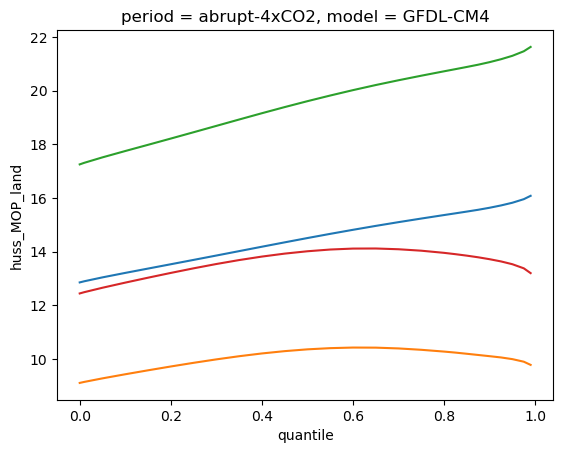

In [5]:
(ds['huss_ocean']*1000).mean(['lat', 'lon']).plot()
(ds['huss_x_land']*1000).mean(['lat', 'lon']).plot()

(ds_4['huss_ocean']*1000).mean(['lat', 'lon']).plot()
(ds_4['huss_MOP_land']*1000).mean(['lat', 'lon']).plot()
# ds['dtas_x_land'].mean(['lat', 'lon']).plot()

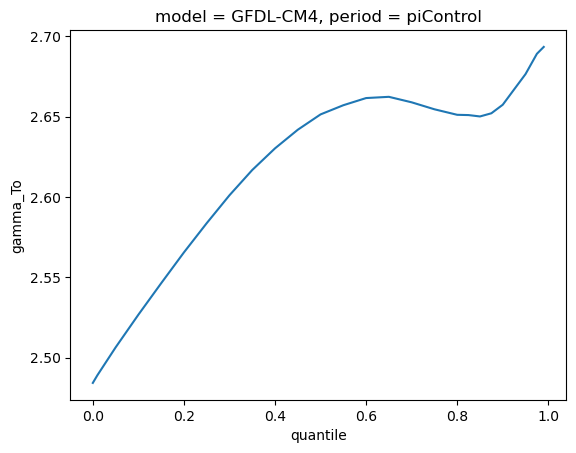

In [7]:
ds.gamma_To.sel(lat = slice(-20, 20)).mean(['lat','lon']).plot()
# ds..plot()

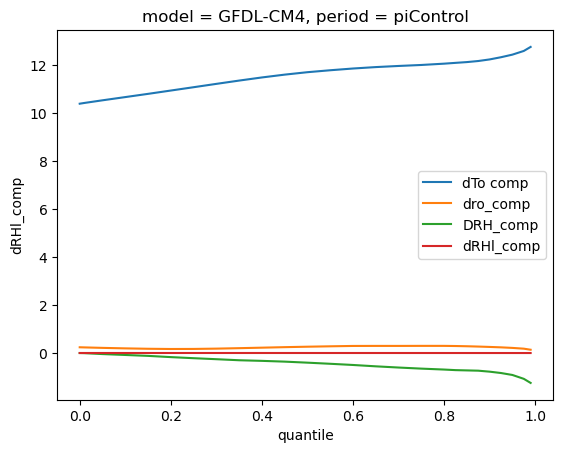

In [8]:
ds['dTo_comp'].mean(['lat' ,'lon']).plot(label = 'dTo comp')
ds['dro_comp'].mean(['lat' ,'lon']).plot(label = 'dro_comp')
ds['DRH_comp'].mean(['lat' ,'lon']).plot(label = 'DRH_comp')
ds['dRHl_comp'].mean(['lat' ,'lon']).plot(label = 'dRHl_comp' )
plt.legend()

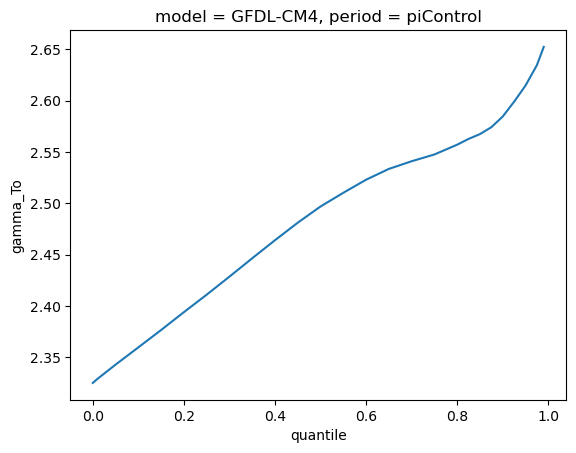

In [9]:
ds.gamma_To.mean(['lat', 'lon']).plot()

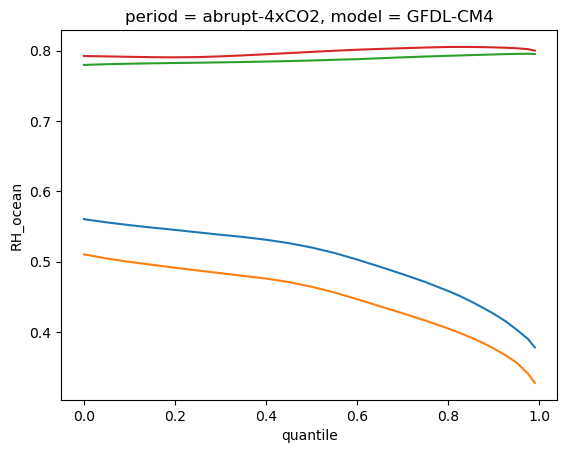

In [10]:

ds_p.RH_x_land.mean(['lat', 'lon']).plot()
ds_4.RH_x_land.mean(['lat', 'lon']).plot()

ds_p.RH_ocean.mean(['lat', 'lon']).plot()
ds_4.RH_ocean.mean(['lat', 'lon']).plot()
# ds.alpha_ocean.mean(['lat', 'lon']).plot()

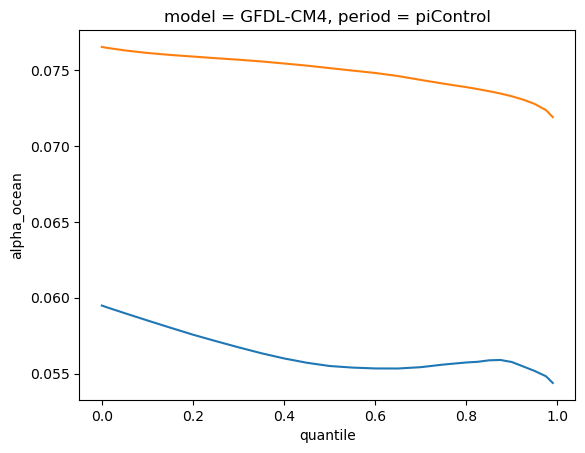

In [9]:

ds.alpha_land.mean(['lat', 'lon']).plot()
ds.alpha_ocean.mean(['lat', 'lon']).plot()

In [4]:
processModel('GFDL-CM4')

840kKiB [00:08, 104kKiB/s]                           


420kKiB [00:03, 108kKiB/s]                           


224kKiB [00:02, 101kKiB/s]                           


112kKiB [00:01, 59.2kKiB/s]                          


Writing to GFDL-CM4_abrupt-4xCO2_tas_processed.nc
[########################################] | 100% Completed | 131.31 s


1.08MKiB [31:33, 569KiB/s]                            


539kKiB [16:23, 548KiB/s]                            


284kKiB [08:24, 563KiB/s]                            


142kKiB [00:14, 10.1kKiB/s]                          


Writing to GFDL-CM4_abrupt-4xCO2_huss_processed.nc
[########################################] | 100% Completed | 133.76 s


69.3kKiB [00:04, 14.8kKiB/s]                          


Writing to GFDL-CM4_abrupt-4xCO2_ps_processed.nc
[########################################] | 100% Completed | 32.48 s


850kKiB [00:08, 98.8kKiB/s]                          


850kKiB [00:07, 107kKiB/s]                           


227kKiB [00:02, 93.9kKiB/s]                          


227kKiB [00:02, 83.3kKiB/s]                          


Writing to GFDL-CM4_piControl_tas_processed.nc
[########################################] | 100% Completed | 139.08 s


1.09MKiB [00:09, 115kKiB/s]                           


1.09MKiB [00:32, 33.7kKiB/s]                          


287kKiB [00:02, 105kKiB/s]                           


287kKiB [00:02, 107kKiB/s]                           


Writing to GFDL-CM4_piControl_huss_processed.nc
[########################################] | 100% Completed | 139.62 s


139kKiB [04:30, 513KiB/s]                            


Writing to GFDL-CM4_piControl_ps_processed.nc
[########################################] | 100% Completed | 32.71 s


In [ ]:
for period in ['piControl', 'abrupt-4xCO2']:
    
    model = 'GFDL-CM4'
    Vars = ['ps', 'tas', 'huss']
    ds = grabDS(model, period, Vars)
    ds = AddLandMask(ds)
    ds = ds.expand_dims(model = [model])
    ds = ds.expand_dims(period = [period])
    ds = CalcSatSpecificHumidity(ds)
    ds = CalcMSE(ds)
    
    quantiles = np.array([0.001, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 82.5, 85, 87.5, 90, 92.5, 95, 97.5, 99])/100
    ds = ds.chunk({"time": -1})
    ds = meanOverPercentile(ds, 'tas', ['tas', 'huss', 'qsat', 'MSE'], quantiles, ['time'], additionalMask = (ds.landseamask == 1), add_brev = '_land')
    
    
    
    MSE_bin_edges = generatePDF_bins(ds.MSE, 500)
    
    ds[f'MSE_pdf'] = generatePDF(ds.MSE, MSE_bin_edges, dimOver = ['time'])
    
    if period == 'abrupt-4xCO2':
        piControlMSEMOP = xr.open_dataset(f'TempData/{model}_piControl_19_12_24.nc').MSE_MOP_land
        piControlMSEMOP = piControlMSEMOP.assign_coords({"period": ['abrupt-4xCO2']})
    
        ds['MSE_land_px']  = estimatePx(ds.MSE_pdf, ds.piControlMSEMOP)
    else:
        ds['MSE_land_px']  = estimatePx(ds.MSE_pdf, ds.MSE_MOP_land)
        
        
    for Var in ['tas', 'huss', 'qsat']:
        
        px = ds.MSE_land_px
            
        bin_edges = generatePDF_bins(ds[Var], 500)
        ds[f'{Var}_pdf'] = generatePDF(ds[Var].where(ds.landseamask == 0), bin_edges, dimOver = ['time', 'lon'])
        ds[f'{Var}_ocean'] = ValuefromPx(ds[f'{Var}_pdf'], px) # tas_pdf is lat, and bins       ds_MSE_land_px is lat lon and quantile over land only
        ds[f'{Var}_land_mean'] = ds[Var].where(ds.landseamask == 1).mean('time')
        
    ds = ds.drop_vars([
     'time',
     'height',
     'huss',
     'ps',
     'tas',
     'qsat',
     'MSE',
     'MSE_pdf',
     'MSE_bins'
     'tas_qant',
     'bins_tas',
     'tas_pdf',
     'bins_huss',
     'huss_pdf',
     'bins_qsat',
     'qsat_pdf'], errors = 'ignore')
    
    ds.to_netcdf(f'TempData/{model}_{period}_19_12_24.nc')
# for Var in ['tas', 'huss', 'ps']: 
#     if os.path.exists(f'{model}_{period}_{Var}_processed.nc'): 
#         os.remove(f'{model}_{period}_{Var}_processed.nc')

(array([1.000000e+00, 0.000000e+00, 0.000000e+00, 2.000000e+00,
        4.000000e+00, 4.000000e+00, 1.200000e+01, 1.800000e+01,
        2.700000e+01, 3.700000e+01, 5.400000e+01, 6.900000e+01,
        6.700000e+01, 1.170000e+02, 1.430000e+02, 2.190000e+02,
        2.560000e+02, 3.000000e+02, 4.250000e+02, 5.110000e+02,
        6.410000e+02, 7.510000e+02, 9.310000e+02, 1.143000e+03,
        1.364000e+03, 1.508000e+03, 1.749000e+03, 2.105000e+03,
        2.385000e+03, 2.705000e+03, 3.135000e+03, 3.550000e+03,
        4.236000e+03, 4.856000e+03, 6.054000e+03, 7.476000e+03,
        9.574000e+03, 1.277500e+04, 1.751000e+04, 2.458200e+04,
        3.474200e+04, 4.982300e+04, 6.999500e+04, 9.474600e+04,
        1.255700e+05, 1.595490e+05, 1.976960e+05, 2.377180e+05,
        2.796740e+05, 3.190200e+05, 3.583580e+05, 3.965010e+05,
        4.360340e+05, 4.723080e+05, 5.068850e+05, 5.377930e+05,
        5.627120e+05, 5.883370e+05, 6.130900e+05, 6.387250e+05,
        6.633370e+05, 6.915820e+05, 7.20

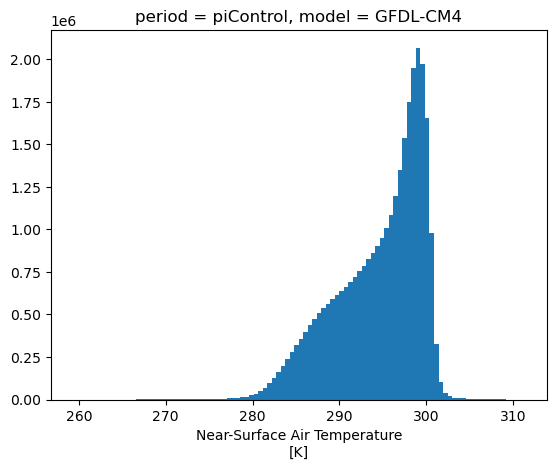

In [11]:
ds.tas.where(ds.landseamask == 0).plot(bins = 100)

/opt/jaspy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


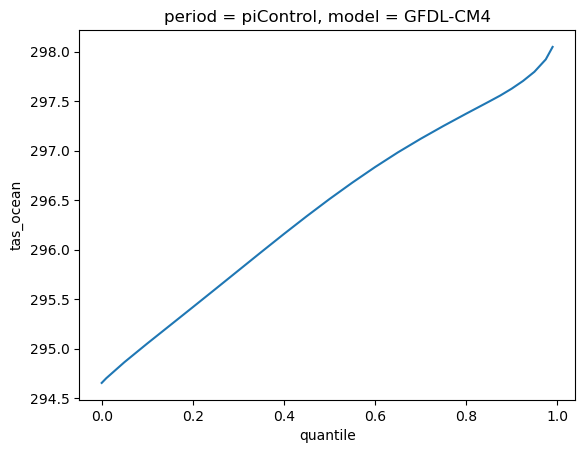

/opt/jaspy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/opt/jaspy/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/opt/jaspy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [14]:
ds.tas_ocean.mean(['lat', 'lon']).plot()

In [ ]:
ds.tas_ocean.mean(['lat', 'lon']).plot()

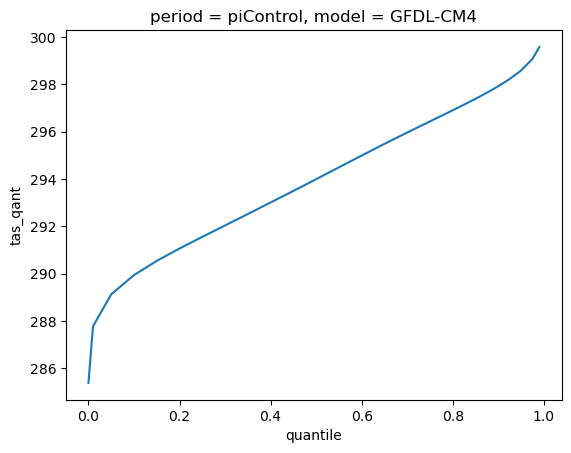

In [19]:
ds.tas_qant.mean(['lat', 'lon']).plot()

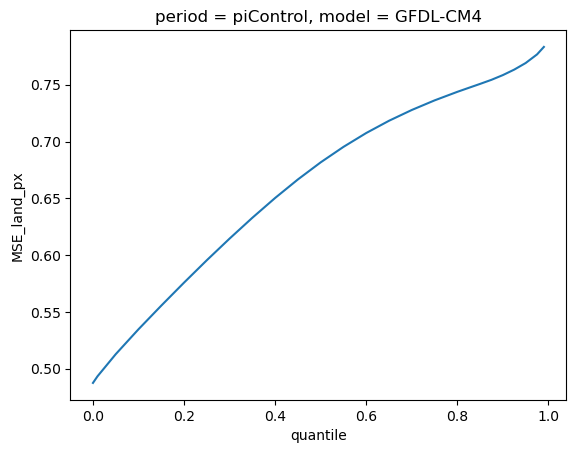

In [22]:
ds.MSE_land_px.mean(['lat', 'lon']).plot()


In [23]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:         (period: 1, model: 1, time: 7300, lat: 80, lon: 288,
                     quantile: 26, bins_MSE: 500, bins_tas: 500,
                     bins_huss: 500, bins_qsat: 500)
Coordinates:
  * period          (period) object 8B 'piControl'
  * model           (model) object 8B 'GFDL-CM4'
  * time            (time) object 58kB 0631-01-01 12:00:00 ... 0650-12-31 12:...
  * lat             (lat) float64 640B -39.5 -38.5 -37.5 ... 37.5 38.5 39.5
  * lon             (lon) float64 2kB 0.625 1.875 3.125 ... 356.9 358.1 359.4
  * quantile        (quantile) float64 208B 1e-05 0.01 0.05 ... 0.95 0.975 0.99
  * bins_MSE        (bins_MSE) float32 2kB 2.281e+05 2.284e+05 ... 3.718e+05
  * bins_tas        (bins_tas) float32 2kB 226.7 226.9 227.1 ... 317.7 317.9
  * bins_huss       (bins_huss) float32 2kB -1.928e-05 3.168e-05 ... 0.02541
  * bins_qsat       (bins_qsat) float32 2kB 0.0002134 0.000334 ... 0.06044
Data variables: (12/22)
    huss            (period, model, time, lat, lon) float32 673MB dask.array<chunksize=(1, 1, 7300, 80, 288), meta=np.ndarray>
    ps              (period, model, time, lat, lon) float32 673MB dask.array<chunksize=(1, 1, 7300, 80, 288), meta=np.ndarray>
    tas             (period, model, time, lat, lon) float32 673MB dask.array<chunksize=(1, 1, 7300, 80, 288), meta=np.ndarray>
    landseamask     (period, model, lat, lon) float32 92kB dask.array<chunksize=(1, 1, 80, 288), meta=np.ndarray>
    qsat            (period, model, time, lat, lon) float32 673MB dask.array<chunksize=(1, 1, 7300, 80, 288), meta=np.ndarray>
    MSE             (period, model, time, lat, lon) float32 673MB dask.array<chunksize=(1, 1, 7300, 80, 288), meta=np.ndarray>
    ...              ...
    huss_pdf        (period, model, lat, bins_huss) float64 320kB dask.array<chunksize=(1, 1, 80, 500), meta=np.ndarray>
    huss_ocean      (period, model, lat, quantile, lon) float64 5MB dask.array<chunksize=(1, 1, 80, 26, 288), meta=np.ndarray>
    huss_land_mean  (period, model, lat, lon) float32 92kB dask.array<chunksize=(1, 1, 80, 288), meta=np.ndarray>
    qsat_pdf        (period, model, lat, bins_qsat) float64 320kB dask.array<chunksize=(1, 1, 80, 500), meta=np.ndarray>
    qsat_ocean      (period, model, lat, quantile, lon) float64 5MB dask.array<chunksize=(1, 1, 80, 26, 288), meta=np.ndarray>
    qsat_land_mean  (period, model, lat, lon) float32 92kB dask.array<chunksize=(1, 1, 80, 288), meta=np.ndarray>

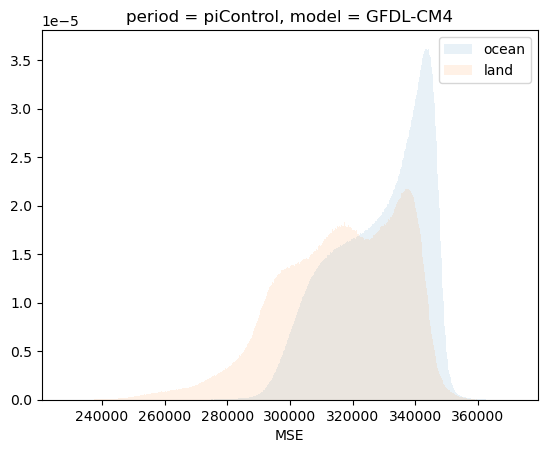

In [28]:
ds.MSE.where(ds.landseamask == 0).plot(bins = 500, alpha = 0.1, label = 'ocean', density = True)
ds.MSE.where(ds.landseamask == 1).plot(bins = 500, alpha = 0.1, label = 'land', density = True)
plt.legend()
plt.show()


In [29]:
ds.tas_pdf.plot()

<xarray.DataArray 'tas_pdf' (period: 1, model: 1, lat: 80, bins_tas: 500)> Size: 320kB
dask.array<transpose, shape=(1, 1, 80, 500), dtype=float64, chunksize=(1, 1, 80, 500), chunktype=numpy.ndarray>
Coordinates:
  * period    (period) object 8B 'piControl'
  * model     (model) object 8B 'GFDL-CM4'
  * lat       (lat) float64 640B -39.5 -38.5 -37.5 -36.5 ... 36.5 37.5 38.5 39.5
  * bins_tas  (bins_tas) float32 2kB 226.7 226.9 227.1 ... 317.6 317.7 317.9